# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [55]:
m = 1
A = 0.100#872627258300784#0.12872631072998048#9#0.001#0.049261572870865834#0.0495#0.04922733211517334#0.04926157287086606#0.049261573076248164#0.04925#55#0.05#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [56]:
(0.12872627258300784+0.12872634887695314)/2

0.12872631072998048

Choose your grid

In [57]:
global compactified=true
global loggrid=true

global bisection=false

false

In [58]:
using Quadmath, Printf

res=m;
N=2.0^m*1000.0/2.0

if compactified==true
    Xf=1.0
else
    Xf=10.0#Float128(1.0);
end

dx=Xf/N#Float128(Xf/N);
if loggrid==false
    dt=0.5*round(dx,digits=10)#0.5*dx#round(dx,digits=10);#dx
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*100.0/2.0
Tf=Nt*dt; #final time
#print(Tf)

In [59]:
print(N)

100.0

In [60]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [61]:
using Printf
include("./ScalarField.jl");
#include("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/myspline.jl");

In [62]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
#initX1=create_range(ori,Xf,dx,N)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)
#initX=create_range(ori-3.0*dx,Xf+3.0*dx,dx,N+6)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.01
the time step is 0.001


# Initial data of m β Ψ and Ψ,x

In [63]:
using Dierckx


####

initm=zeros(L)
initbeta=zeros(L)
initpsi=zeros(L)
initderpsi=zeros(L)
#initm=Array{Float128}(undef, L)
#initbeta=Array{Float128}(undef, L)
#initpsi=Array{Float128}(undef, L)
#initderpsi=Array{Float128}(undef, L)

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#Float128(0.7)#0.01#0.7#0.01#0.7#0.7#0.7#0.01#0.7#0.3
sigma=0.3#Float128(0.3)


#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)


state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);

In [64]:
#derpsi_func(state_array[:,5]); #doesnt output the quad precision
#coef=splinethree(state_array[4:L-3,5],state_array[4:L-3,4],state_array[4:L-3,5]);

In [65]:
#evalInterval(Float128.([0.1]),initX,coef,3);

In [66]:
y0=Float128.([0.0 0.0 0.0])

state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:]);

state_array = ghost(state_array);

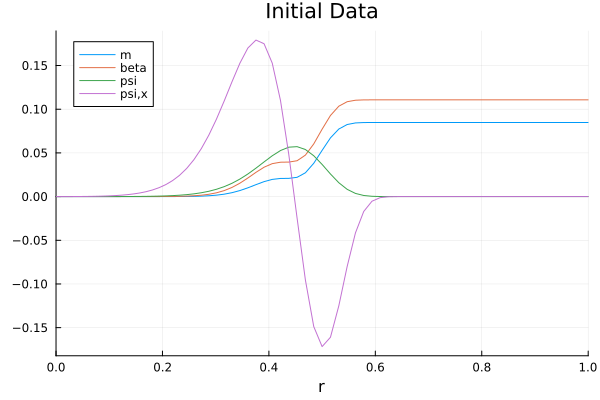

In [67]:
using Plots #showing initial data and the initial status of the horizon finder
plot((initX[4:L-3]), state_array[4:L-3,1:4], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "psi,x"],xlim=[0,1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [68]:
using CSV, Tables
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "derpsi"]

print_muninn(files, 0, state_array[:,1:5],res,"w")

In [69]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
global monitor_ratio = zeros(L);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

In [70]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

0.24684160353934748


In [71]:
using Base.Threads
Threads.nthreads()

4

 ## Time evolution

fixed grid

In [73]:
finaltime=3.0
evol_stats, T_interp = timeevolution(state_array,finaltime,run);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);



iteration 20 dt is 0.00024684160353933204, t=0.004936832070786745 speed is 0.4997533106182552, dx/dt=40.511809421974476


iteration 40 dt is 0.00024684160353932516, t=0.009873664141573313 speed is 0.4997533106182691, dx/dt=40.511809421975606


iteration 60 dt is 0.0002468416035393172, t=0.014810496212359733 speed is 0.49975331061828526, dx/dt=40.51180942197691


iteration 80 dt is 0.00024684160353930716, t=0.019747328283145973 speed is 0.4997533106183056, dx/dt=40.51180942197856


iteration 100 dt is 0.00024684160353929545, t=0.024684160353932 speed is 0.4997533106183292, dx/dt=40.51180942198048


iteration 120 dt is 0.0002468416035392821, t=0.02962099242471777 speed is 0.49975331061835626, dx/dt=40.51180942198267


iteration 140 dt is 0.0002468416035392664, t=0.03455782449550325 speed is 0.49975331061838807, dx/dt=40.51180942198525


iteration 160 dt is 0.0002468416035392479, t=0.039494656566288394 speed is 0.49975331061842554, dx/dt=40.51180942198828


iteration 180 dt is 0.0002468



iteration 1380 dt is 0.00024684160342513406, t=0.34064141285836924 speed is 0.4997533108494594, dx/dt=40.511809440716725


iteration 1400 dt is 0.0002468416034157322, t=0.34557824492677436 speed is 0.4997533108684943, dx/dt=40.51180944225977


iteration 1420 dt is 0.0002468416034056537, t=0.35051507699498424 speed is 0.49975331088889907, dx/dt=40.511809443913855


iteration 1440 dt is 0.0002468416033948574, t=0.3554519090629852 speed is 0.49975331091075725, dx/dt=40.511809445685756


iteration 1460 dt is 0.00024684160338330055, t=0.36038874113076225 speed is 0.4997533109341551, dx/dt=40.51180944758247


iteration 1480 dt is 0.0002468416033709382, t=0.3653255731982999 speed is 0.49975331095918385, dx/dt=40.511809449611384


iteration 1500 dt is 0.0002468416033577234, t=0.37026240526558146 speed is 0.4997533109859384, dx/dt=40.51180945178021


iteration 1520 dt is 0.00024684160334360736, t=0.3751992373325891 speed is 0.4997533110145176, dx/dt=40.51180945409694


iteration 1540 dt is 0.



iteration 2740 dt is 0.00024684159762422856, t=0.6763459912563824 speed is 0.49975332259392125, dx/dt=40.51181039276525


iteration 2760 dt is 0.00024684159739332944, t=0.6812828232064513 speed is 0.4997533230613975, dx/dt=40.51181043066057


iteration 2780 dt is 0.0002468415971569297, t=0.686219655151845 speed is 0.4997533235400104, dx/dt=40.51181046945866


iteration 2800 dt is 0.000246841596915086, t=0.6911564870924533 speed is 0.49975332402964495, dx/dt=40.5118105091502


iteration 2820 dt is 0.00024684159666786727, t=0.6960933190281681 speed is 0.4997533245301619, dx/dt=40.51181054972391


iteration 2840 dt is 0.00024684159641535545, t=0.7010301509588829 speed is 0.49975332504139514, dx/dt=40.51181059116632


iteration 2860 dt is 0.00024684159615764563, t=0.7059669828844926 speed is 0.4997533255631521, dx/dt=40.511810633461835


iteration 2880 dt is 0.00024684159589484674, t=0.7109038148048945 speed is 0.49975332609521245, dx/dt=40.51181067659257


iteration 2900 dt is 0.0002468



iteration 4100 dt is 0.0002468415846461175, t=1.0120505519825718 speed is 0.4997533488692918, dx/dt=40.51181252274174


iteration 4120 dt is 0.00024684158488970327, t=1.016987383678013 speed is 0.49975334837613017, dx/dt=40.511812482764284


iteration 4140 dt is 0.00024684158515653524, t=1.0219242153785704 speed is 0.49975334783590447, dx/dt=40.51181243897163


iteration 4160 dt is 0.00024684158544647253, t=1.0268610470847068 speed is 0.49975334724889997, dx/dt=40.511812391386925


iteration 4180 dt is 0.0002468415857592913, t=1.0317978787968831 speed is 0.49975334661556975, dx/dt=40.51181234004689


iteration 4200 dt is 0.0002468415860946812, t=1.036734710515553 speed is 0.4997533459365423, dx/dt=40.51181228500247


iteration 4220 dt is 0.00024684158645224167, t=1.0416715422411646 speed is 0.4997533452126284, dx/dt=40.51181222631939


iteration 4240 dt is 0.0002468415868314785, t=1.0466083739741558 speed is 0.49975334444482883, dx/dt=40.51181216407878


iteration 4260 dt is 0.000246



iteration 5460 dt is 0.0002468415885321998, t=1.347755122164991 speed is 0.49975334100156327, dx/dt=40.51181188495523


iteration 5480 dt is 0.00024684158731253414, t=1.3526919539228979 speed is 0.49975334347088773, dx/dt=40.5118120851276


iteration 5500 dt is 0.000246841586051819, t=1.3576287856559783 speed is 0.4997533460233207, dx/dt=40.51181229203704


iteration 5520 dt is 0.0002468415847514212, t=1.3625656173634255 speed is 0.49975334865609494, dx/dt=40.51181250545923


iteration 5540 dt is 0.000246841583412726, t=1.3675024490444605 speed is 0.49975335136640575, dx/dt=40.51181272516682


iteration 5560 dt is 0.0002468415820371299, t=1.3724392806983319 speed is 0.4997533541514258, dx/dt=40.51181295093061


iteration 5580 dt is 0.00024684158062603497, t=1.377376112324316 speed is 0.49975335700831647, dx/dt=40.5118131825205


iteration 5600 dt is 0.0002468415791808425, t=1.3823129439217174 speed is 0.4997533599342409, dx/dt=40.511813419706506


iteration 5620 dt is 0.0002468415777



iteration 6820 dt is 0.0002468414806881954, t=1.6834596059466809 speed is 0.49975355934169535, dx/dt=40.5118295843954


iteration 6840 dt is 0.00024684148042894183, t=1.6883964355574794 speed is 0.4997535598665783, dx/dt=40.51182962694431


iteration 6860 dt is 0.00024684148032012946, t=1.693333265164658 speed is 0.4997535600868791, dx/dt=40.51182964480269


iteration 6880 dt is 0.00024684148037087267, t=1.6982700947713203 speed is 0.4997535599841447, dx/dt=40.51182963647467


iteration 6900 dt is 0.00024684148059034007, t=1.703206924380754 speed is 0.49975355953981254, dx/dt=40.5118296004555


iteration 6920 dt is 0.00024684148098767057, t=1.70814375399643 speed is 0.4997535587353799, dx/dt=40.51182953524528


iteration 6940 dt is 0.00024684148157187654, t=1.713080583622 speed is 0.4997535575526006, dx/dt=40.51182943936492


iteration 6960 dt is 0.00024684148235173096, t=1.7180174132612938 speed is 0.49975355597371274, dx/dt=40.511829311374555


iteration 6980 dt is 0.00024684148333



iteration 8180 dt is 0.00024684156521560905, t=2.0191641147563417 speed is 0.49975338820813525, dx/dt=40.51181571169056


iteration 8200 dt is 0.00024684156349385697, t=2.0241009460423838 speed is 0.49975339169398025, dx/dt=40.51181599426575


iteration 8220 dt is 0.00024684156189007064, t=2.02903777729522 speed is 0.4997533949409928, dx/dt=40.511816257480326


iteration 8240 dt is 0.0002468415604093477, t=2.0339746085172656 speed is 0.4997533979388524, dx/dt=40.51181650049765


iteration 8260 dt is 0.0002468415590554228, t=2.0389114397110237 speed is 0.4997534006799975, dx/dt=40.51181672270479


iteration 8280 dt is 0.0002468415578307754, t=2.0438482708790575 speed is 0.4997534031594087, dx/dt=40.511816923694816


iteration 8300 dt is 0.00024684155673673877, t=2.0487851020239685 speed is 0.49975340537438634, dx/dt=40.51181710324891


iteration 8320 dt is 0.0002468415557736086, t=2.053721933148372 speed is 0.4997534073243319, dx/dt=40.51181726131854


iteration 8340 dt is 0.000246841



iteration 9540 dt is 0.00024684159610956, t=2.354868650242362 speed is 0.4997533256605058, dx/dt=40.51181064135368


iteration 9560 dt is 0.0002468415965800298, t=2.3598054821695316 speed is 0.49975332470799677, dx/dt=40.51181056413986


iteration 9580 dt is 0.0002468415970275999, t=2.364742314105869 speed is 0.49975332380185034, dx/dt=40.51181049068435


iteration 9600 dt is 0.0002468415974528797, t=2.369679146050924 speed is 0.4997533229408327, dx/dt=40.511810420887144


iteration 9620 dt is 0.0002468415978565028, t=2.374615978004255 speed is 0.49975332212366086, dx/dt=40.51181035464425


iteration 9640 dt is 0.0002468415982391219, t=2.3795528099654373 speed is 0.4997533213490136, dx/dt=40.51181029184853


iteration 9660 dt is 0.0002468415986014054, t=2.384489641934056 speed is 0.4997533206155377, dx/dt=40.511810232390324


iteration 9680 dt is 0.0002468415989440335, t=2.3894264739097135 speed is 0.49975331992185573, dx/dt=40.511810176157965


iteration 9700 dt is 0.000246841599267



iteration 10900 dt is 0.00024684160353626375, t=2.690573229169856 speed is 0.4997533106244672, dx/dt=40.511809422478045


iteration 10920 dt is 0.0002468416035355722, t=2.695510061240574 speed is 0.49975331062586736, dx/dt=40.51180942259155


iteration 10940 dt is 0.00024684160353482187, t=2.700446893311278 speed is 0.4997533106273864, dx/dt=40.51180942271469


iteration 10960 dt is 0.0002468416035340293, t=2.7053837253819664 speed is 0.499753310628991, dx/dt=40.51180942284476


iteration 10980 dt is 0.00024684160353320933, t=2.7103205574526386 speed is 0.4997533106306511, dx/dt=40.51180942297934


iteration 11000 dt is 0.00024684160353237466, t=2.715257389523294 speed is 0.49975331063234096, dx/dt=40.511809423116325


iteration 11020 dt is 0.0002468416035315364, t=2.7201942215939323 speed is 0.4997533106340381, dx/dt=40.5118094232539


iteration 11040 dt is 0.0002468416035307044, t=2.7251310536645543 speed is 0.4997533106357226, dx/dt=40.51180942339045


iteration 11060 dt is 0.0002

#### 

In [ ]:
run bisec like this with just N1=1000
conv test on this with 150 points, dt =1e-4, A=0.1

 ## Movie of the evolution, apparent horizon formation for 0.0492<A*<0.04925

In [48]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 710:710
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0.0, 0.1])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step710.csv" is not a valid file or doesn't exist

In [49]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8000:100:10000
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot6=functions3.Column1[4:L-3] .* 2 .* (1 .- functions3.Column5[4:L-3]) ./functions3.Column5[4:L-3];
    
    
    plot!(initX1, plot6, labels=["monitor ratio"], ylim=[-1.3, 0.6],xlim=[0.0, 0.3])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step8000.csv" is not a valid file or doesn't exist

In [50]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

In [141]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8200:5:8430
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1],xlim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1500)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/monitor_ratio8200.csv" is not a valid file or doesn't exist

Sanity check for der func

In [207]:
array=init_gaussian(originalX,0.7,0.3,0.01)
arrayloggrid=init_gaussian(initX,0.7,0.3,0.01);

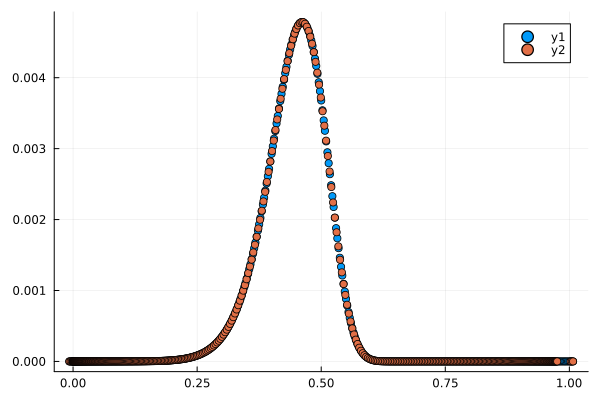

In [209]:
scatter([originalX, initX], [array, arrayloggrid])

In [210]:
aux=zeros(L)

loggrid=false
for i in 4:L-3
    aux[i]=Dertest(array,i,originalX)
end
x1=originalX
y1=aux


loggrid=true
for i in 4:L-3
    aux[i]=Dertest(arrayloggrid,i,initX)
end
x2=initX
y2=aux;

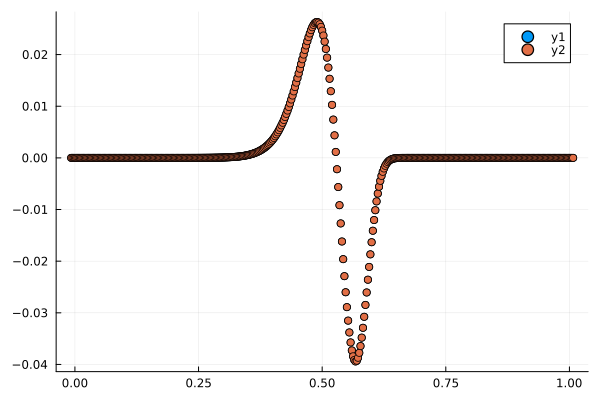

In [417]:
scatter([x1,x1],[y1,y2])